In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import wrangle
import model
import model_MAE

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from math import sqrt
from scipy import stats

In [2]:
df, train_exp, X_train_scaled, y_train, X_test_scaled, y_test = wrangle.wrangle_data()

Acquire: compiling raw data files...
Acquire: Completed!
Prepare: preparing data files...
Prepare: Completed!
(289, 25) (73, 25)


In [3]:
X_train_scaled.columns

Index(['raw_svi', 'f_pov_soci', 'f_unemp_soci', 'f_pci_soci', 'f_nohsdp_soci',
       'f_age65_comp', 'f_age17_comp', 'f_disabl_comp', 'f_sngpnt_comp',
       'f_minrty_status', 'f_limeng_status', 'f_munit_trans', 'f_mobile_trans',
       'f_crowd_trans', 'f_noveh_trans', 'f_groupq_trans',
       'f_soci_total_scaled', 'f_comp_total_scaled', 'f_status_total_scaled',
       'f_trans_total_scaled', 'all_flags_total_scaled', 'rank_svi_scaled'],
      dtype='object')

# Create Baseline

In [4]:
y_train.tract_cases_per_100k.mean(), y_train.tract_cases_per_100k.median()

(3201.968351790576, 2903.7827641596423)

In [5]:
# MAE
mean_baseMAE, basepred1 = model_MAE.get_baseline_mean(y_train)

Baseline MAE: 973.0351509141836


In [6]:
# using mean
mean_baseRMSE, basepred = model.get_baseline_mean(y_train)

Baseline RMSE: 1257.2466801311145


In [7]:
# using median
median_baseMAE, basepred2 = model_MAE.get_baseline_median(y_train)

Baseline MAE: 950.9798103241462


In [8]:
# using median
median_baseRMSE, basepred = model.get_baseline_median(y_train)

Baseline RMSE: 1292.1237786572597


# Feature Ranking

In [9]:
# possible feature ranking?
rankdf = model.feature_ranking(X_train_scaled, y_train)
rankdf

,features
rank,
1,rank_svi_scaled
2,f_soci_total_scaled
3,f_pov_soci
4,f_minrty_status
5,all_flags_total_scaled
6,f_groupq_trans
7,f_age17_comp
8,f_comp_total_scaled
9,f_munit_trans


# Create X_train_scaled df with selected features to test

## Feature groups to use for OLS, PF, and Tweedie models

In [10]:
# only raw svi score
X_raw_svi = X_train_scaled[['raw_svi']]
# binned svi score by CDC range category = 1st ranked
X_rank_svi_only = X_train_scaled[['rank_svi_scaled']]
# top 4 ranked features
X_top4 = X_train_scaled[['rank_svi_scaled', 'f_nohsdp_soci', 'f_minrty_status', 'f_groupq_trans']]
# only the summary of the flags = 19th ranked
X_all_flags_only = X_train_scaled[['all_flags_total_scaled']]
# only summary flags, should be the same as all flags total? = 5th, 12th, 15th, 21st
X_summary_flags = X_train_scaled[['f_comp_total_scaled', 'f_soci_total_scaled', 'f_status_total_scaled', 'f_trans_total_scaled']]
# all individual flags
X_not_summary_flags = X_train_scaled[['f_nohsdp_soci', 'f_minrty_status', 'f_groupq_trans', 'f_unemp_soci', 
                                     'f_disabl_comp', 'f_noveh_trans', 'f_mobile_trans', 'f_age65_comp', 
                                     'f_age17_comp', 'f_pov_soci', 'f_limeng_status', 'f_crowd_trans', 
                                      'f_pci_soci', 'f_sngpnt_comp', 'f_munit_trans']]

## LassoLars
- includes feature selection as part of model so will use all features on this model

## Drilling in features to test -- RETURN HERE

- what is the score using only 1 summary flag at a time?
    - if one summary group is better might be worth investigating for which features within group have greatest impact?

# Run df through regression algorithms

In [11]:
# create variables for loop
df2test = [X_rank_svi_only, X_top4, X_all_flags_only, X_summary_flags, X_not_summary_flags, X_train_scaled, X_raw_svi]
target = y_train

# Linear Regression Models
lm_MAE_list = []
for df in df2test:
    lm_MAE = model_MAE.linear_reg_train(df, target)
    lm_MAE_list.append(lm_MAE)

# Polynomial Features 2 degree
pf2_MAE_list = []
for df in df2test:
    pf2_MAE = model_MAE.polynomial2(df, target)
    pf2_MAE_list.append(pf2_MAE)

# Tweedie power=0, alpha=.5
tweedie05 = []
for df in df2test:
    tw_MAE = model_MAE.tweedie05(df, target)
    tweedie05.append(tw_MAE)


In [12]:
# # create variables for loop
# df2test = [X_rank_svi_only, X_top5, X_all_flags_only, X_summary_flags, X_not_summary_flags, X_train_scaled]
# target = y_train

# # Linear Regression Models
# lm_RMSE_list = []
# for df in df2test:
#     lm_RMSE = model.linear_reg_train(df, target)
#     lm_RMSE_list.append(lm_RMSE)

# # Polynomial Features 2 degree
# pf2_RMSE_list = []
# for df in df2test:
#     pf2_RMSE = model.polynomial2(df, target)
#     pf2_RMSE_list.append(pf2_RMSE)

# # Tweedie power=0, alpha=.5
# tweedie05 = []
# for df in df2test:
#     tw_RMSE = model.tweedie05(df, target)
#     tweedie05.append(tw_RMSE)


In [13]:
# LassoLars Models
lars_MAE = model_MAE.lasso_lars(X_train_scaled, target)

In [14]:
# LassoLars Models
lars_RMSE = model.lasso_lars(X_train_scaled, target)

# Summarize in results df

In [15]:
# create dataframe for results of all train models
df_list = ['rank_svi_only', 'top5', 'total_all_flags_only', 'summary_flags', 'not_summary_flags', 'all_features', 'raw_svi_only']

results = pd.DataFrame(df_list, columns=['Features'])
results['LinearRegression_MAE'] = lm_MAE_list
results['Tweedie05_MAE'] = tweedie05
results['PolynomialFeatures2_MAE'] = pf2_MAE_list
results['LassoLars_MAE'] = lars_MAE
results['Base_mean_MAE'] = mean_baseMAE
results['Base_median_MAE'] = median_baseMAE
results.sort_values('PolynomialFeatures2_MAE')

,Features,LinearRegression_MAE,Tweedie05_MAE,PolynomialFeatures2_MAE,LassoLars_MAE,Base_mean_MAE,Base_median_MAE
5,all_features,694.319979,821.826107,416.712011,697.418073,973.035151,950.97981
4,not_summary_flags,768.309031,890.061139,523.157408,697.418073,973.035151,950.97981
1,top5,733.964872,872.729805,715.532379,697.418073,973.035151,950.97981
6,raw_svi_only,776.969617,924.491852,767.016031,697.418073,973.035151,950.97981
0,rank_svi_only,775.678114,900.500732,772.144027,697.418073,973.035151,950.97981
3,summary_flags,830.585295,944.466544,780.583376,697.418073,973.035151,950.97981
2,total_all_flags_only,865.391283,958.467458,850.094118,697.418073,973.035151,950.97981


In [16]:
# # create dataframe for results of all train models
# df_list = ['rank_svi_only', 'top5', 'total_all_flags_only', 'summary_flags', 'not_summary_flags', 'all_features', 'raw_svi_only']

# results = pd.DataFrame(df_list, columns=['Features'])
# results['LinearRegression_RMSE'] = lm_RMSE_list
# results['Tweedie05_RMSE'] = tweedie05
# results['PolynomialFeatures2_RMSE'] = pf2_RMSE_list
# results['LassoLars_RMSE'] = lars_RMSE
# results['Base_mean_RMSE'] = mean_baseRMSE
# results['Base_median_RMSE'] = median_baseRMSE
# results.sort_values('PolynomialFeatures2_RMSE')

# Validate Stage

## pick models to validate
- LassoLars
- LR all feature
- PF2 all features
- PF2 top5


In [17]:
from numpy import mean
from numpy import std, absolute
from sklearn.datasets import make_blobs
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

In [18]:
# LassoLars
# create loocv procedure
cvLL = LeaveOneOut()
# create model
modelLL = LassoLars(alpha=1)
# evaluate model
scoresLL = cross_val_score(modelLL, X_train_scaled, y_train, scoring='neg_mean_absolute_error', cv=cvLL, n_jobs=-1)
# force positive
scoresLL = absolute(scoresLL)
# report performance
print('MAE: %.3f (%.3f)' % (mean(scoresLL), std(scoresLL)))

MAE: 745.523 (707.596)


In [19]:
# Linear Regression - all features
# create loocv procedure
cvLR = LeaveOneOut()
# create model
modelLR = LinearRegression()
# evaluate model
scoresLR = cross_val_score(modelLR, X_train_scaled, y_train, scoring='neg_mean_absolute_error', cv=cvLR, n_jobs=-1)
# force positive
scoresLR = absolute(scoresLR)
# report performance
print('MAE: %.3f (%.3f)' % (mean(scoresLR), std(scoresLR)))

MAE: 753.715 (722.317)


In [20]:
# Polynomial Features 2 degrees - all features
# create loocv procedure
cvPF1 = LeaveOneOut()

# create PF object
pf1 = PolynomialFeatures(degree=2)
# Fit and Transform model to get a new set of features...which are the original features squared
X_train_squared1 = pf1.fit_transform(X_train_scaled)

# create model
modelPF1 = LinearRegression(normalize=True)
# evaluate model
scoresPF1 = cross_val_score(modelPF1, X_train_squared1, y_train, scoring='neg_mean_absolute_error', cv=cvPF1, n_jobs=-1)
# force positive
scoresPF1 = absolute(scoresPF1)
# report performance
print('MAE: %.3f (%.3f)' % (mean(scoresPF1), std(scoresPF1)))

MAE: 644168580363410.125 (3241353656002645.500)


In [21]:
# Polynomial Features 2 degrees - top 5
# create loocv procedure
cvPF2 = LeaveOneOut()

# create PF object
pf2 = PolynomialFeatures(degree=2)
# Fit and Transform model to get a new set of features...which are the original features squared
X_train_squared2 = pf2.fit_transform(X_top4)

# create model
modelPF2 = LinearRegression(normalize=True)
# evaluate model
scoresPF2 = cross_val_score(modelPF2, X_train_squared2, y_train, scoring='neg_mean_absolute_error', cv=cvPF2, n_jobs=-1)
# force positive
scoresPF2 = absolute(scoresPF2)
# report performance
print('MAE: %.3f (%.3f)' % (mean(scoresPF2), std(scoresPF2)))

MAE: 763.343 (638.873)


# Test 

In [22]:
# fit model from cross validation to train dataset
modelLL.fit(X_train_scaled, y_train)
# use the trained dataset to predict on test
lars_test_pred = modelLL.predict(X_test_scaled)
# get the MAE of test
lars_MAE = mean_absolute_error(y_test, lars_test_pred)
print('MAE: %.3f' % lars_MAE)

MAE: 853.068


In [23]:
modelLL.coef_

array([    0.        ,  -266.44166894,   642.56062808,   463.69130524,
         219.57817805,  -242.49315328,  -600.6779376 ,   163.26130203,
           0.        ,   771.6833059 ,     0.        ,   156.42395614,
         -91.04033532,     0.        ,  -349.35134   ,   535.61386987,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        , -1219.80815463])

In [24]:
X_train_scaled.head()

,raw_svi,f_pov_soci,f_unemp_soci,f_pci_soci,f_nohsdp_soci,f_age65_comp,f_age17_comp,f_disabl_comp,f_sngpnt_comp,f_minrty_status,...,f_mobile_trans,f_crowd_trans,f_noveh_trans,f_groupq_trans,f_soci_total_scaled,f_comp_total_scaled,f_status_total_scaled,f_trans_total_scaled,all_flags_total_scaled,rank_svi_scaled
289,0.4879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.000000,0.0,0.000000,0.000000,0.666667
200,0.6394,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.000000,0.0,0.333333,0.111111,0.333333
69,0.6523,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0.0,0.000000,0.5,0.333333,0.222222,0.333333
29,0.0872,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.000000,0.0,0.000000,0.000000,1.000000
12,0.9531,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0.0,0.333333,0.0,0.000000,0.111111,0.000000


In [25]:
ll_coef_count = (modelLL.coef_ != 0)

In [26]:
ll_coef = modelLL.coef_ 

In [27]:
ll_coef

array([    0.        ,  -266.44166894,   642.56062808,   463.69130524,
         219.57817805,  -242.49315328,  -600.6779376 ,   163.26130203,
           0.        ,   771.6833059 ,     0.        ,   156.42395614,
         -91.04033532,     0.        ,  -349.35134   ,   535.61386987,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        , -1219.80815463])

In [28]:
rankdf

,features
rank,
1,rank_svi_scaled
2,f_soci_total_scaled
3,f_pov_soci
4,f_minrty_status
5,all_flags_total_scaled
6,f_groupq_trans
7,f_age17_comp
8,f_comp_total_scaled
9,f_munit_trans


In [29]:
ll_result = pd.DataFrame()
x_train_columns = X_train_scaled.columns.tolist()
ll_result['features'] = x_train_columns
ll_result['coefs'] = modelLL.coef_
ll_result['abs_coefs'] = abs(modelLL.coef_)
ll_result.sort_values(by = 'abs_coefs', ascending = False)

,features,coefs,abs_coefs
21,rank_svi_scaled,-1219.808155,1219.808155
9,f_minrty_status,771.683306,771.683306
2,f_unemp_soci,642.560628,642.560628
6,f_age17_comp,-600.677938,600.677938
15,f_groupq_trans,535.613870,535.613870
3,f_pci_soci,463.691305,463.691305
14,f_noveh_trans,-349.351340,349.351340
1,f_pov_soci,-266.441669,266.441669
5,f_age65_comp,-242.493153,242.493153
4,f_nohsdp_soci,219.578178,219.578178


In [30]:
rank_df = rankdf.copy()
rank_df = rank_df.reset_index()
rank_df

,rank,features
0,1,rank_svi_scaled
1,2,f_soci_total_scaled
2,3,f_pov_soci
3,4,f_minrty_status
4,5,all_flags_total_scaled
5,6,f_groupq_trans
6,7,f_age17_comp
7,8,f_comp_total_scaled
8,9,f_munit_trans
9,10,f_age65_comp


In [31]:
comparison = pd.merge(ll_result, rank_df, on = 'features', how = 'inner')
comparison = comparison.set_index("index")

KeyError: "None of ['index'] are in the columns"

In [ ]:
comparison

In [32]:
rfe_ll_comp.sort_values(by = 'abs_coefs', ascending = False)

NameError: name 'rfe_ll_comp' is not defined

In [ ]:
abs(ll_coef)

In [ ]:
abs(modelLL.coef_)

In [33]:
modelLL.coef_

array([    0.        ,  -266.44166894,   642.56062808,   463.69130524,
         219.57817805,  -242.49315328,  -600.6779376 ,   163.26130203,
           0.        ,   771.6833059 ,     0.        ,   156.42395614,
         -91.04033532,     0.        ,  -349.35134   ,   535.61386987,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        , -1219.80815463])

In [36]:
m_log_alphas = -np.log10(modelLL.alphas_) # alpha contains the values of alpha through the model selection process.

In [37]:
import numpy as np

In [57]:
modelLL

LassoLars(alpha=1)

In [60]:
modelLL.coef_path_

array([[ 0.00000000e+00,  2.13610954e+03,  3.31218060e+03,
         3.22875706e+03,  3.02276415e+03,  2.11113458e+03,
         2.03963999e+03,  1.96322014e+03,  1.74000054e+03,
         1.63099031e+03,  9.12773546e+02, -1.13686838e-13,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.47865546e+02, -7.51439672e+02, -1.33983862e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.15853818e+02,  4.19403530e+02,  5.69840064e+02,
         6.83501392e+02,  1.11092366e+03,  1.57057256e+03,
         1.70507365e+03,  1.77708103e+03,  2.14774789e

In [63]:
modelLL.coef_path_.shape, modelLL.alphas_.shape

((22, 18), (18,))

(-1.6051837159435585, -0.0)

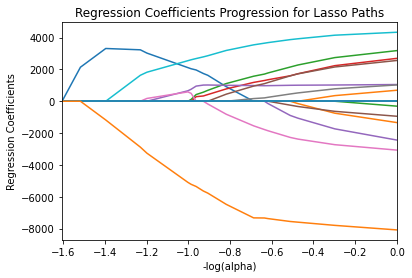

In [54]:
# %matplotlib inline
ax = plt.gca()

m_log_alphas = -np.log10(modelLL.alphas_) # alpha contains the values of alpha through the model selection process.
# plt.figure(figsize = (16, 9))
plt.plot(m_log_alphas, modelLL.coef_path_.T) # change in regression coefficient
np.shape(modelLL.coef_path_), np.shape(m_log_alphas)

# plt.axvline(-np.log10(modelLL.alphas_), linestyle='--', color='k',
#             label='alpha CV')

plt.ylabel('Regression Coefficients')
plt.xlabel('-log(alpha)')
plt.title('Regression Coefficients Progression for Lasso Paths')
ax.set_xlim(m_log_alphas.min(), m_log_alphas.max())
# plt.show()

Text(0.5, 1.0, 'Regression Coefficients Progression for Lasso Paths')

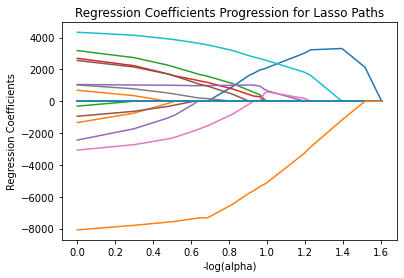

In [56]:
# %matplotlib inline
ax = plt.gca()

m_log_alphas_pos = np.log10(modelLL.alphas_) # alpha contains the values of alpha through the model selection process.
# plt.figure(figsize = (16, 9))
plt.plot(m_log_alphas_pos, modelLL.coef_path_.T) # change in regression coefficient
np.shape(modelLL.coef_path_), np.shape(m_log_alphas_pos)

# plt.axvline(-np.log10(modelLL.alphas_), linestyle='--', color='k',
#             label='alpha CV')

plt.ylabel('Regression Coefficients')
plt.xlabel('-log(alpha)')
plt.title('Regression Coefficients Progression for Lasso Paths')
# ax.set_xlim(m_log_alphas_pos.min(), m_log_alphas_pos.max())
# plt.show()

In [ ]:
modelLL.alphas_

In [ ]:
ll_paths = modelLL.coef_path_

In [ ]:
import mglearn

In [ ]:
mglearn.plots.plot_ridge_n_samples()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.plot(modelLL.coef_, 's', label="Lasso alpha=1")
plt.plot(modelLL.coef_, '^', label="Lasso alpha=0.01")
plt.plot(modelLL.coef_, 'v', label="Lasso alpha=0.0001")
plt.xlabel('Log($\\lambda$)')
plt.show()

In [ ]:
modelLL.coef_

In [ ]:
modelLL.coef_path_

In [ ]:
# assuming you have variables X_train and lm
pd.Series(dict(zip(X_train_scaled.columns, modelLL.coef_.ravel()))).sort_values()

In [ ]:
modelLL.intercept_

In [ ]:
modelLL.n_iter_

In [ ]:
modelLL.alphas_

In [ ]:
modelLL.alphas_.shape, modelLL.coef_path_.shape

In [ ]:
m_log_alphas = -np.log10(modelLL.alphas_)

In [ ]:
modelLL.coef_.T.shape

In [ ]:
fig,ax = plt.subplots()
ax.plot(m_log_alphas, modelLL.coef_.T)
# Set log scale
ax.set_xscale('log')
# Make alpha decrease from left to right
ax.set_xlim(alphas_.max(), alphas_.min())

In [ ]:
# I need to figure out a way to plot an array of lists = this is what I need to create that nice line chart I wanted to make.

modelLL.coef_path_[0].shape

In [ ]:
modelLL.coef_path_

In [ ]:
modelLL.coef_

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
model

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import eli5

In [ ]:
train_values = pd.read_csv('train_values.csv')
train_labels = pd.read_csv('train_labels.csv')
train_data = train_values.merge(train_labels, left_on='building_id', right_on='building_id')

In [ ]:
train_data.dtypes

In [ ]:
train_data = train_data.drop('building_id', axis=1)
numeric_features = train_data.select_dtypes(include=['int64', 'float64']).drop(['damage_grade'], axis=1).columns
categorical_features = train_data.select_dtypes(include=['object']).columns
X = train_data.drop('damage_grade', axis=1)
y = train_data['damage_grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('one_hot', OneHotEncoder())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',  LogisticRegression(class_weight='balanced', random_state=0))])
    
model = pipe.fit(X_train, y_train)

In [ ]:
target_names = y_test.unique().astype(str)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
onehot_columns = list(pipe.named_steps['preprocessor'].named_transformers_['cat'].named_steps['one_hot'].get_feature_names(input_features=categorical_features))
numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)

In [ ]:
eli5.explain_weights(pipe.named_steps['classifier'], top=50, feature_names=numeric_features_list)

In [ ]:
numeric_features